# Ripple phase modulation

In [2]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
import itertools
from scipy import stats

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import phase_by_time

from pycircstat import descriptive as desc
from pycircstat import distributions as dist
from pycircstat import tests as circ_test

## Load data

In [3]:
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
save_path = "F:/Projects/PAE_PlaceCell/analysis/ripple_modulation_phase/"
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')
display(df_cell_class)


df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')
display(df)


,Unnamed: 0,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,...,trough,spkW,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area
0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,3.757487,...,-2.393640,0.777777,0.021529,1.149097,1.535871,2.529014,3.181064,7340,pyr,ca1
1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,7.293023,...,-2.027969,0.930761,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1
2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,4.657924,...,-2.491995,0.777777,0.041928,1.235779,1.773778,2.580697,3.908416,7490,pyr,ca1
3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,1.285490,...,-2.784299,0.571703,0.000555,1.032228,0.999013,0.621228,3.730098,1803,pyr,ca1
4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,4.588725,...,-2.683800,0.684153,0.011062,0.983793,1.406165,2.959360,3.743105,8589,pyr,ca1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508,8508,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,0.086722,...,-2.886261,0.529358,0.000000,1.059228,5.973929,0.789008,4.629547,1252,pyr,ca1
8509,8509,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,0.000135,...,-3.028445,0.271706,0.004489,0.735687,23.134516,13.056442,2.818769,20718,int,ca1
8510,8510,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,0.000087,...,-2.461559,0.286010,0.000000,0.955257,6.281825,0.626417,21.188431,994,int,ca1
8511,8511,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,0.011953,...,-2.361157,0.701930,0.021382,0.999326,31.814075,1.533272,2.350860,2433,pyr,ca1


,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,area,ep_type,group,rat
0,0,22,211.247200,211.327200,0.080000,0.990871,211.296000,3,5.566472,213.605249,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
1,1,60,517.919200,518.311200,0.392000,0.995188,518.087200,7,29.168512,203.155556,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
2,2,72,607.938400,608.326400,0.388000,0.990928,607.964000,3,7.932019,103.616382,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
3,3,80,675.985600,676.139200,0.153600,0.994272,676.074400,7,5.077734,173.913383,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
4,4,100,933.226400,933.424000,0.197600,0.992893,933.278400,7,27.285162,119.721685,0.000000,LEM3116_S20180715121821,ca1,pedestal_2,control,LEM3116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18199,18728,25,255.450400,255.599200,0.148800,0.314032,255.533600,7,8.094016,105.746020,0.000000,RH16_S20161126145021,ca1,track,pae,RH16
18200,18729,22,149.384000,149.505600,0.121600,0.133732,149.436800,6,12.060743,186.017137,0.000000,RH16_S20161126150318,ca1,track,pae,RH16
18201,18730,32,233.419200,233.576000,0.156800,0.260312,233.496000,7,8.145433,110.793201,0.000000,RH16_S20161126150318,ca1,track,pae,RH16
18202,18731,36,270.288000,270.410400,0.122400,0.065024,270.328800,0,4.390508,174.380797,0.000000,RH16_S20161126150318,ca1,track,pae,RH16


In [7]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def smoothAngularTuningCurves(tuning_curve,deviation=3):
    n_bins = len(tuning_curve)
    padded = np.hstack([tuning_curve,tuning_curve,tuning_curve])
    padded = gaussian_filter1d(padded, deviation)
    return padded[n_bins:n_bins+n_bins]

def spike_phase_maps(spikes,phase,ts,df,session,fs=1250,n_bins=60):

    bin_edges = np.linspace(-np.pi,np.pi,n_bins+1)
    bin_width = np.diff(bin_edges)[0]
    bin_centers = np.linspace(-np.pi+bin_width/2 ,np.pi-bin_width/2, n_bins)
    
    # loop through spikes
    spk_phase_all = []
    phase_counts = []
    binned_phase = []
    smoothed_phase = []
    peak_phase = []
    spk_count = []
    resultant = []
    kappa = []
    rayleigh_z = []
    rayleigh_pval = []
    
    for spk in spikes:
        spk_phase = []
        occ_phase = []
        for ripple in df[df.session == session].itertuples():
            # restrict spikes to current ripple
            current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
            # collect interp phase for each spike
            spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))
            # collect occ phases for normalization
            occ_phase.append(phase[(ts >= ripple.peak_time - 0.1) & (ts <= ripple.peak_time + 0.1),int(ripple.peak_channel)])

        # flatten phases into nice list    
        x = list(itertools.chain(*spk_phase)) 
        x2 = list(itertools.chain(*occ_phase))    
        # bin from -pi to pi
        y, _ = np.histogram(x, bins=bin_edges)
        y2, _ = np.histogram(x2, bins=bin_edges)
        
        # convert to firing rate in Hz
        tuning = y / (y2 / fs)
        
        # smooth and find max phase
        smooth_y = smoothAngularTuningCurves(tuning)
        max_phase = bin_centers[np.argmax(smooth_y)]
        
        pval, z = circ_test.rayleigh(bin_centers, w=smooth_y, d=bin_width)

        n_spikes = y.sum()
        
        # append for each cell
        spk_phase_all.append(x)
        phase_counts.append(y)
        binned_phase.append(tuning)
        smoothed_phase.append(smooth_y)
        peak_phase.append(max_phase)
        spk_count.append(n_spikes)

        # circ stats
        resultant.append(desc.resultant_vector_length(bin_centers, w=smooth_y, d=bin_width,axis=0))
        kappa.append(dist.kappa(bin_centers, w=smooth_y))
        rayleigh_z.append(z)
        rayleigh_pval.append(pval)

    return spk_phase_all,binned_phase,phase_counts,smoothed_phase,peak_phase,spk_count,resultant,kappa,rayleigh_z,rayleigh_pval

In [ ]:
# loop though sessions

def main(session,df,data_path,savepath):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'

    # check if saved file exists
    if os.path.exists(save_file):
        return

    path = get_session_path(data_path+session+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs)
    
    phase = np.stack([phase_by_time(lfp_,fs,f_range=(80,250),remove_edges=False) for lfp_ in lfp.T])
    phase = phase.T
    
    # load spikes
    spikes = get_spikes(data_path+session+'.mat')
    
    spk_phase_all,binned_phase,phase_counts,smoothed_phase,peak_phase,spk_count,resultant,kappa,rayleigh_z,rayleigh_pval = spike_phase_maps(spikes,phase,ts,df,session,fs=fs)
        
    # save all cells in a session to file    
    with open(save_file, 'wb') as f:
        pickle.dump(spk_phase_all, f)
        pickle.dump(binned_phase, f)  
        pickle.dump(phase_counts,f)
        pickle.dump(smoothed_phase, f)  
        pickle.dump(peak_phase, f)
        pickle.dump(spk_count, f)
        pickle.dump(resultant, f)
        pickle.dump(kappa, f)  
        pickle.dump(rayleigh_z, f)  
        pickle.dump(rayleigh_pval, f)

sessions = pd.unique(df.session)
# for session in sessions:
#     main(session,df,data_path,save_path)
    
num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main)(session,df,data_path,save_path) for session in sessions)


D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
def load_in_everything(save_path):
    
    spk_phase_all = []
    binned_phase = []
    phase_counts = []
    smoothed_phase = []
    peak_phase = []
    spk_count = []
    resultant = []
    kappa = []
    rayleigh_z = []
    rayleigh_pval = []
    
    sessions = glob.glob(save_path + '*.pkl')
    for session in sessions:
        with open(session, 'rb') as f:
            spk_phase_all.append(pickle.load(f))
            binned_phase.append(pickle.load(f))
            phase_counts.append(pickle.load(f))
            smoothed_phase.append(pickle.load(f))
            peak_phase.append(pickle.load(f))
            spk_count.append(pickle.load(f))
            resultant.append(pickle.load(f))
            kappa.append(pickle.load(f))
            rayleigh_z.append(pickle.load(f))
            rayleigh_pval.append(pickle.load(f))
            
    binned_phase = np.vstack(binned_phase)
    phase_counts = np.hstack(phase_counts)
    smoothed_phase = np.vstack(smoothed_phase)
    peak_phase = np.hstack(peak_phase)
    spk_count = np.hstack(spk_count)
    resultant = np.hstack(resultant)
    kappa = list(itertools.chain(*kappa))
    rayleigh_z = np.hstack(rayleigh_z)
    rayleigh_pval = np.hstack(rayleigh_pval)
    
    
    mod_dict = {
        "spk_phase": spk_phase_all,
        "binned_phase": binned_phase,
        "phase_counts": phase_counts,
        "smoothed_phase": smoothed_phase,
        "peak_phase": peak_phase,
        "spk_count": spk_count,
        "resultant": resultant,
        "kappa": kappa,
        "rayleigh_z": rayleigh_z,
        "rayleigh_pval": rayleigh_pval
    }
    return mod_dict

mod_dict = load_in_everything(save_path)

mod_dict.keys()

# Testing below

In [6]:
session = 'LEM3216_S20190805141510'

path = get_session_path(data_path+session+'.mat')

# load xml which has channel & fs info
channels,fs,shank = loadXML(path)

# get good channels
good_ch = get_good_channels(shank)

lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)

phase = np.stack([phase_by_time(lfp_,fs,f_range=(80,250),remove_edges=False) for lfp_ in lfp.T])
phase = phase.T

In [7]:
# load spikes
spikes = get_spikes(data_path+session+'.mat')
    

In [170]:
df[df.session == session].shape[0] * 0.2

164.8

In [183]:
6*60

360

In [185]:
bins=60
bins = np.arange(-np.pi,np.pi,2*np.pi/bins)
np.diff(bins)
bins

bins = np.linspace(-np.pi,np.pi,61)


In [207]:
# n_bin=21
# bins = np.linspace(-np.pi,np.pi,n_bin)
# bin_centers = np.linspace(-np.pi+np.diff(bins)[0]/2 ,np.pi-np.diff(bins)[0]/2, n_bin)
degree_bins = 18
bin_width = degree_bins * np.pi / 180

bin_edges = np.arange(-np.pi,np.pi+bin_width,bin_width)
print(bin_edges)

bin_centers = bin_edges = np.arange(-np.pi + bin_width/2,(np.pi+bin_width) - bin_width/2,bin_width)
print(bin_centers)


[-3.14159265 -2.82743339 -2.51327412 -2.19911486 -1.88495559 -1.57079633
 -1.25663706 -0.9424778  -0.62831853 -0.31415927  0.          0.31415927
  0.62831853  0.9424778   1.25663706  1.57079633  1.88495559  2.19911486
  2.51327412  2.82743339  3.14159265]
[-2.98451302 -2.67035376 -2.35619449 -2.04203522 -1.72787596 -1.41371669
 -1.09955743 -0.78539816 -0.4712389  -0.15707963  0.15707963  0.4712389
  0.78539816  1.09955743  1.41371669  1.72787596  2.04203522  2.35619449
  2.67035376  2.98451302]


(20,)

In [216]:
n_bin=60
bins = np.linspace(-np.pi,np.pi,n_bin+1)
bin_centers = np.linspace(-np.pi+np.diff(bins)[0]/2 ,np.pi-np.diff(bins)[0]/2, n_bin)
print(bins.shape)
print(bin_centers.shape)

(61,)
(60,)


In [225]:
nb_bins = 60
bins = np.linspace(0, 2*np.pi, nb_bins)
idx = bins[0:-1]+np.diff(bins)/2

print(bins)
print(idx)

[0.         0.10649467 0.21298933 0.319484   0.42597866 0.53247333
 0.638968   0.74546266 0.85195733 0.958452   1.06494666 1.17144133
 1.27793599 1.38443066 1.49092533 1.59741999 1.70391466 1.81040933
 1.91690399 2.02339866 2.12989332 2.23638799 2.34288266 2.44937732
 2.55587199 2.66236666 2.76886132 2.87535599 2.98185065 3.08834532
 3.19483999 3.30133465 3.40782932 3.51432399 3.62081865 3.72731332
 3.83380798 3.94030265 4.04679732 4.15329198 4.25978665 4.36628132
 4.47277598 4.57927065 4.68576531 4.79225998 4.89875465 5.00524931
 5.11174398 5.21823864 5.32473331 5.43122798 5.53772264 5.64421731
 5.75071198 5.85720664 5.96370131 6.07019597 6.17669064 6.28318531]
[0.05324733 0.159742   0.26623667 0.37273133 0.479226   0.58572066
 0.69221533 0.79871    0.90520466 1.01169933 1.118194   1.22468866
 1.33118333 1.43767799 1.54417266 1.65066733 1.75716199 1.86365666
 1.97015133 2.07664599 2.18314066 2.28963532 2.39612999 2.50262466
 2.60911932 2.71561399 2.82210865 2.92860332 3.03509799 3.141

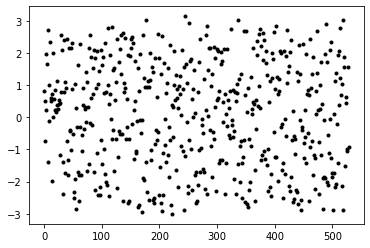

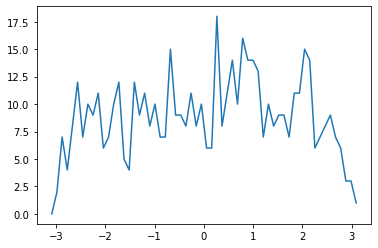

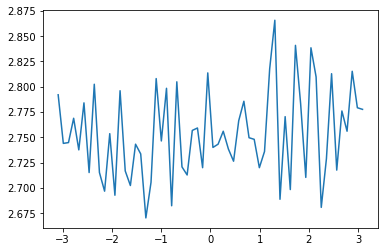

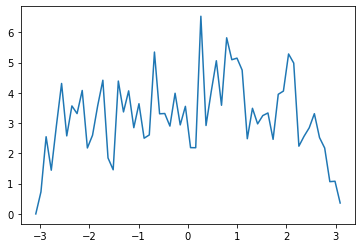

In [15]:
# bins=19
# bins = np.arange(-np.pi,np.pi,2*np.pi/bins)
n_bin=60
bin_edges = np.linspace(-np.pi,np.pi,n_bin+1)
bin_centers = np.linspace(-np.pi+np.diff(bin_edges)[0]/2 ,np.pi-np.diff(bin_edges)[0]/2, n_bin)
# degree_bins = 18
# bin_width = degree_bins * np.pi / 180
# bin_edges = np.arange(-np.pi,np.pi+bin_width,bin_width)
# bin_centers = bin_edges = np.arange(-np.pi + bin_width/2,(np.pi+bin_width) - bin_width/2,bin_width)

spk = spikes[6]
spk_phase = []
occ_phase = []
for ripple in df[df.session == session].itertuples():
    # restrict spikes to current ripple
    current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
    # collect interp phase for each spike
    spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))
    # collect occ phases for normalization
    occ_phase.append(phase[(ts >= ripple.peak_time - 0.1) & (ts <= ripple.peak_time + 0.1),int(ripple.peak_channel)])
    
# flatten phases into nice list    
x = list(itertools.chain(*spk_phase))     
x2 = list(itertools.chain(*occ_phase))     

# bin from -pi to pi
y, _ = np.histogram(x,bins=bin_edges)
y2, _ = np.histogram(x2,bins=bin_edges)


plt.figure()
plt.plot(x,'.k')

plt.figure()
plt.plot(bin_centers,y)
plt.figure()
plt.plot(bin_centers,y2/1250)

y = y / (y2/1250)
plt.figure()
plt.plot(bin_centers,y)


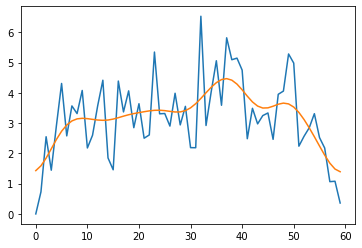

In [16]:

def smoothAngularTuningCurves(tuning_curve,deviation=3):
    n_bins = len(tuning_curve)
    padded = np.hstack([tuning_curve,tuning_curve,tuning_curve])
    padded = gaussian_filter1d(padded, deviation)
    return padded[n_bins:n_bins+n_bins]

smooth_y = smoothAngularTuningCurves(y)

plt.figure()
plt.plot(y)
plt.plot(smooth_y)

In [40]:
# import pycircstat.descriptive as pcs
# from pycircstat.descriptive import resultant_vector_length
from pycircstat import descriptive as desc
from pycircstat import distributions as dist
from pycircstat import tests as circ_test


n_bin=60
bin_edges = np.linspace(-np.pi,np.pi,n_bin+1)
bin_centers = np.linspace(-np.pi+np.diff(bin_edges)[0]/2 ,np.pi-np.diff(bin_edges)[0]/2, n_bin)

resultant = desc.resultant_vector_length(bin_centers, w=smooth_y, d=np.diff(bin_edges)[0],axis=0)
resultant

kappa = dist.kappa(bin_centers, w=smooth_y)
print(kappa)

pval, z = circ_test.rayleigh(bin_centers, w=smooth_y, d=np.diff(bin_edges)[0])

print(pval)
print(z)

[0.26855764]
0.03297019853544012
3.405881288402911


In [ ]:
bins = np.arange(-np.pi,np.pi,2*np.pi/bins)
# loop through spikes
spk_phase_all = []
binned_phase = []
fitted_phase = []
peak_phase = []
for spk in spikes:
    spk_phase = []
    for ripple in df[df.session == session].itertuples():
        # restrict spikes to current ripple
        current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
        # collect interp phase for each spike
        spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))
    # flatten phases into nice list    
    x = list(itertools.chain(*spk_phase))    
    # bin from -pi to pi
    y, bin_edges = np.histogram(x,bins=bins)
    # fit data to vonmises
    try:
        kappa, loc, scale = stats.vonmises.fit(x, fscale=1)
        # create vonmises pdf 
        r = stats.vonmises.pdf(bins,kappa=kappa, loc=loc, scale=scale)
        # find peak phase 
        max_phase = bins[np.argmax(r)]
    except ValueError:
        r = np.zeros(60,)
        max_phase = np.nan
    # append for each cell
    spk_phase_all.append(x)
    binned_phase.append(y)
    fitted_phase.append(r)
    peak_phase.append(max_phase)